In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from numpy.typing import ArrayLike

import typing as tp
import gc

%matplotlib inline

In [2]:
K = 20
SEED = 123
np.random.seed(SEED)

# DATA & EDA

In [4]:
# ! pip install rs-datasets

In [3]:
from rs_datasets import MovieLens

In [4]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [5]:
def get_log_info(log, user_id="user_id", item_id="item_id"):
    print(
        "Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}".format(
            log.shape[0], log[user_id].nunique(), log[item_id].nunique()
        )
    )

In [6]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews["timestamp"] = pd.to_datetime(reviews["timestamp"], unit="s")
reviews.head(1)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40


In [7]:
reviews.isna().sum()

user_id      0
item_id      0
relevance    0
timestamp    0
dtype: int64

In [8]:
data.users.isna().sum()

user_id       0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64

In [9]:
data.items.isna().sum()

item_id    0
title      0
genres     0
dtype: int64

Активность пользователей в оставленни оценок:

In [10]:
user2reviewcnt = reviews[["user_id", "relevance"]].groupby("user_id").count()
user2reviewcnt

,relevance
user_id,
1,53
2,129
3,51
4,21
5,198
...,...
6036,888
6037,202
6038,20


In [11]:
data.users["user_id"].nunique()

6040

Видим, что каждый пользователь оставлял хотя бы одну оценку. Тогда посмотрим на рапсределение пользователей по количеству оценок:

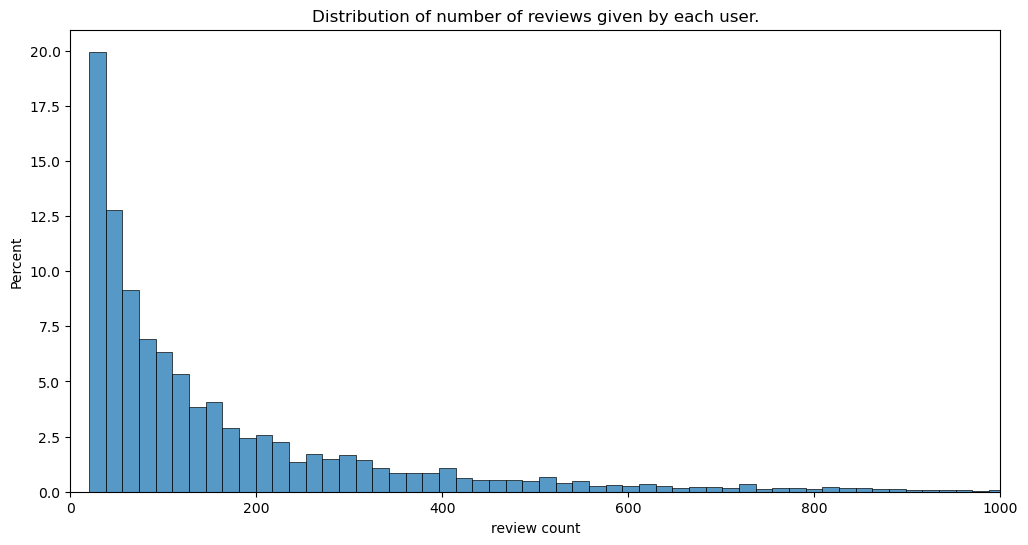

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(data=user2reviewcnt["relevance"], stat="percent")
plt.xlabel("review count")
plt.xlim((0, 1000))  # setting borders for better visualization
plt.title("Distribution of number of reviews given by each user.")
plt.show()

In [13]:
print(user2reviewcnt.describe()["relevance"].apply(int))

count    6040
mean      165
std       192
min        20
25%        44
50%        96
75%       208
max      2314
Name: relevance, dtype: int64


**Observation:** Видим, что чаще люди оставляют примерно по 20 оценок, а среднее количество оценок от каждого пользователя примерно 165, что намного меньше максимального количества. Но таких супер-активных пользователей довольно мало.

In [14]:
item2reviewcnt = reviews[["item_id", "relevance"]].groupby("item_id").count()
item2reviewcnt

,relevance
item_id,
1,2077
2,701
3,478
4,170
5,296
...,...
3948,862
3949,304
3950,54


In [15]:
data.items["item_id"].nunique()

3883

Видим, что у 3883 - 3706 = 177 фильмов нету оценок, и скорее всего их мы никому не сможем порекомендовать. Проставим в них количество оценок 0, чтобы правильно посчитать статистики:

In [16]:
unreviewed_films = list(
    set(data.items["item_id"].unique()).difference(item2reviewcnt.index.values)
)
unreviewed_df = pd.DataFrame(
    data={"item_id": unreviewed_films, "relevance": [0] * len(unreviewed_films)}
).set_index("item_id")
item2reviewcnt = pd.concat((item2reviewcnt, unreviewed_df))
item2reviewcnt

,relevance
item_id,
1,2077
2,701
3,478
4,170
5,296
...,...
979,0
983,0
1001,0


In [17]:
print(item2reviewcnt.describe()["relevance"].apply(int))

count    3883
mean      257
std       379
min         0
25%        26
50%       109
75%       330
max      3428
Name: relevance, dtype: int64


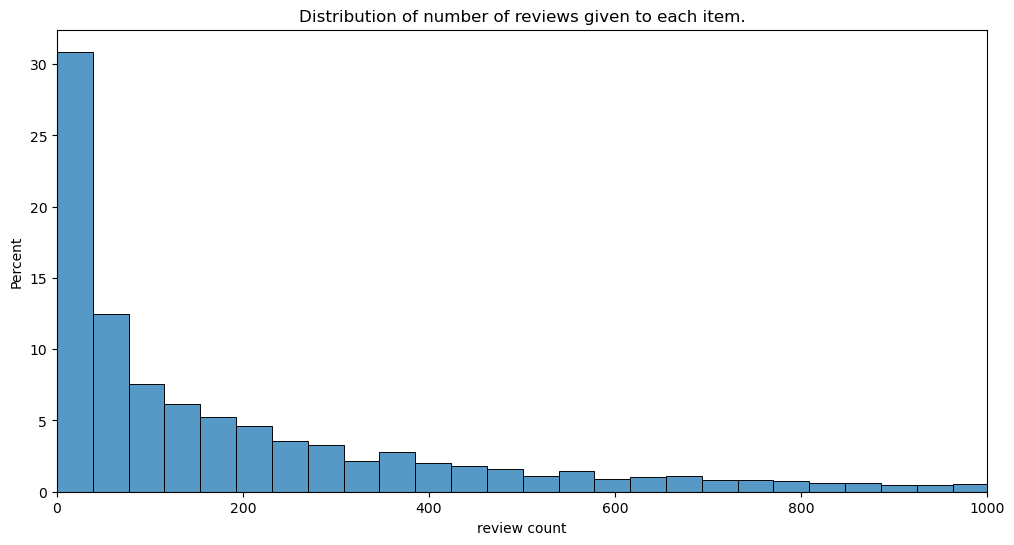

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(data=item2reviewcnt["relevance"], stat="percent")
plt.xlabel("review count")
plt.xlim((0, 1000))  # setting borders for better visualization
plt.title("Distribution of number of reviews given to each item.")
plt.show()

**Наблюдение:** В этом случае наблюдаем примерно такое же распределение как с пользователями, т.е. чаще всего у фильмов меньше 50 оценок.

Посмотрим на распределение оценок:

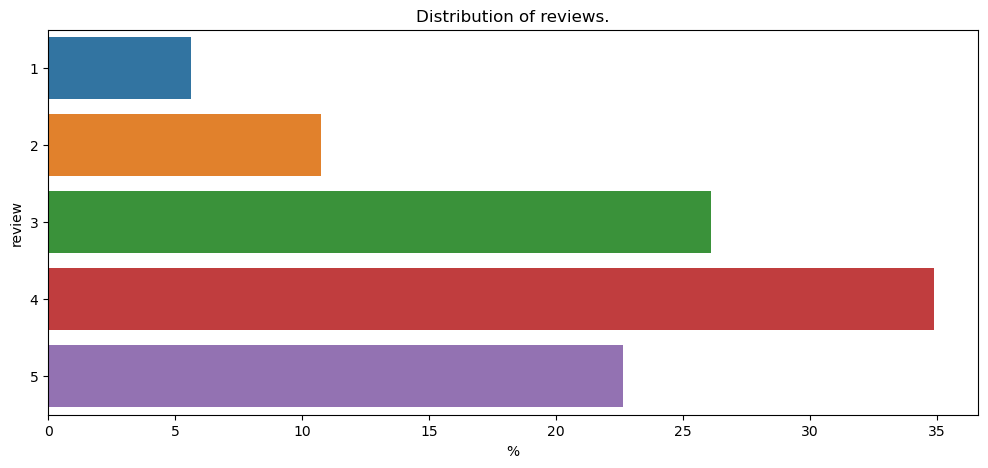

In [19]:
relevance_np = reviews["relevance"].to_numpy()
uniq, cnt = np.unique(relevance_np, return_counts=True)
fraq = 100 * cnt.astype(np.float32) / len(relevance_np)
plt.figure(figsize=(12, 5))
sns.barplot(x=fraq, y=uniq, orient="h")
plt.xlabel("%")
plt.ylabel("review")
plt.title("Distribution of reviews.")
plt.show()

**Observation:** можем увидеть, что в примерно в 83% случаях, люди ставят оценки >= 3

In [20]:
date2item = reviews[["timestamp", "relevance"]].copy()
date2item["month"] = date2item["timestamp"].dt.to_period("M")
month_cnt = date2item[["month", "relevance"]].groupby("month").count()

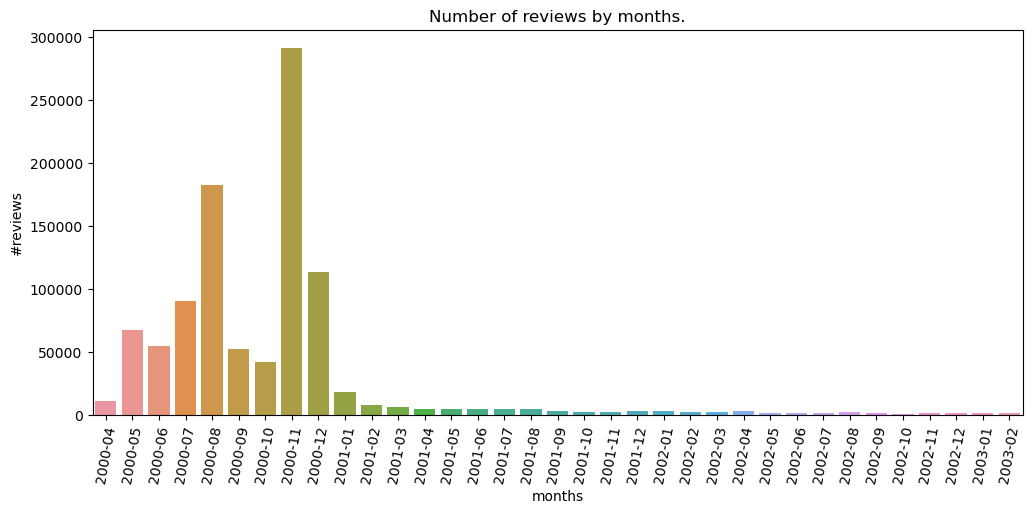

In [21]:
yval = month_cnt["relevance"].to_numpy()
xval = month_cnt.index.strftime("%Y-%m").values
plt.figure(figsize=(12, 5))
sns.barplot(x=xval, y=yval)
plt.xticks(rotation=80)
plt.xlabel("months")
plt.ylabel("#reviews")
plt.title("Number of reviews by months.")
plt.show()

**Observation:** можно увидеть, что самая высокая активность в ноябре 2000 года, и в целом в 2000 году люди больше ставили оценок чем в остальные года. Начиная с 2001 можно наблюдать резкий спад в активности пользователей.

In [22]:
def split_by_date(
    to_split: pd.DataFrame,
    lower_date: pd.Timestamp = pd.to_datetime("2000-12-01"),
    upper_date: pd.Timestamp = pd.to_datetime("2000-12-31"),
) -> tp.Tuple[pd.DataFrame]:
    train_df = to_split[to_split["timestamp"] < lower_date].copy()
    val_df = to_split[
        (to_split["timestamp"] >= lower_date)
        & (to_split["timestamp"] <= upper_date)
        & (to_split["relevance"] > 3)
    ].copy()

    warm_users = train_df["user_id"].unique()
    cold_users = set(to_split["user_id"].unique()).difference(warm_users)

    rows_to_drop = []
    for i, row in val_df.iterrows():
        if row["user_id"] in cold_users:
            rows_to_drop.append(i)

    val_df.drop(rows_to_drop, axis=0, inplace=True)
    return train_df, val_df

In [23]:
train_df, val_df = split_by_date(reviews)

In [24]:
assert train_df.shape[0] == 791270
assert val_df.shape[0] == 14790

In [25]:
get_log_info(train_df)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [26]:
get_log_info(val_df)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


# METRICS


### NDCG

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [30]:
import math
from collections import defaultdict

In [31]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    pred_list = row["pred_list"]
    gt_list = set(row["gt_list"])
    dcg = 0.0
    idcg = 0.0
    for i in range(1, k + 1):
        if i <= len(pred_list) and pred_list[i - 1] in gt_list:
            dcg += np.log(2) / np.log(i + 1)
        if i <= len(gt_list):
            idcg += np.log(2) / np.log(i + 1)
    ndcg = 0.0
    if idcg != 0:
        ndcg = dcg / idcg
    return ndcg

In [32]:
assert math.isclose(
    ndcg_user(
        pd.Series({"user_id": 1, "pred_list": [1, 2, 3], "gt_list": [4, 5, 2, 6]}), k=3
    ),
    0.296,
    abs_tol=1e-3,
)
assert math.isclose(
    ndcg_user(
        pd.Series({"user_id": 1, "pred_list": [1, 2, 3], "gt_list": [4, 5, 2, 6]}), k=5
    ),
    0.246,
    abs_tol=1e-3,
)
assert math.isclose(
    ndcg_user(
        pd.Series({"user_id": 1, "pred_list": [1, 2, 3], "gt_list": [4, 5, 2, 6]}), k=1
    ),
    0.0,
    abs_tol=1e-3,
)
assert math.isclose(
    ndcg_user(
        pd.Series({"user_id": 1, "pred_list": [], "gt_list": [4, 5, 2, 6]}), k=10
    ),
    0,
)
assert math.isclose(
    ndcg_user(pd.Series({"user_id": 1, "pred_list": [1, 3], "gt_list": []}), k=10), 0
)

In [33]:
from abc import ABC, abstractmethod


class Metric(ABC):
    @abstractmethod
    def __call__(self, pred_df: pd.DataFrame, k: int) -> float:
        pass

In [34]:
class NDCG(Metric):
    def __init__(self, gold_df: pd.DataFrame):
        self.gold_df = gold_df

    def __call__(self, pred_df: pd.DataFrame, k: int) -> float:
        all_users = self.gold_df["user_id"].unique()
        metric = 0.0
        for user in all_users:
            user_df = pred_df[pred_df["user_id"] == user].sort_values(
                by="relevance", ascending=False
            )
            pred_list = user_df["item_id"].to_list()
            gt_list = self.gold_df[self.gold_df["user_id"] == user]["item_id"].to_list()
            metric += ndcg_user(
                pd.Series(
                    {"user_id": user, "pred_list": pred_list, "gt_list": gt_list}
                ),
                k=k,
            )
        return metric / len(all_users)

In [35]:
ndcg = NDCG(gold_df=val_df)
ndcg(random_pred, k=20)

0.008261439059285468

### Surprisal

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$ 
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

In [36]:
class Surprisal(Metric):
    def __init__(self, log: pd.DataFrame):
        self.info = {}
        self.N = log["user_id"].nunique()
        item_groups = log.groupby("item_id")["user_id"]
        for item, group in item_groups:
            n_users = group.nunique()
            self.info[item] = (np.log(self.N) - np.log(n_users)) / np.log(2)

    def __call__(self, pred_df: pd.DataFrame, k: int) -> float:
        all_users = pred_df["user_id"].unique()
        metric = 0.0
        for user in all_users:
            user_df = pred_df[pred_df["user_id"] == user].sort_values(
                by="relevance", ascending=False
            )
            pred_list = user_df["item_id"].to_list()
            metric += self._metric_by_user(
                pred_list,
                k=k,
            )
        return metric / len(all_users)

    def _metric_by_user(self, pred_list: tp.Iterable, k: int) -> float:
        info_sum = 0.0
        upper_bound = min(k, len(pred_list))
        for i in range(upper_bound):
            item = pred_list[i]
            if item not in self.info:
                self.info[item] = np.log(self.N) / np.log(2)
            info_sum += self.info[item]
        return (info_sum * np.log(2)) / (k * np.log(self.N))

In [37]:
surp = Surprisal(
    pd.DataFrame(
        {
            "user_id": [1, 2, 3, 3],
            "item_id": [1, 2, 2, 3],
            "relevance": [0.5, 0.1, 1.0, 0.1],
        }
    )
)
assert math.isclose(
    surp(pd.DataFrame({"user_id": [1], "item_id": [4], "relevance": [0.5]}), k=1), 1
)
assert math.isclose(
    surp(pd.DataFrame({"user_id": [1], "item_id": [4], "relevance": [0.5]}), k=2), 0.5
)
assert math.isclose(
    surp(
        pd.DataFrame({"user_id": [2, 2], "item_id": [3, 2], "relevance": [0.1, 1]}), k=2
    ),
    0.685,
    abs_tol=1e-3,
)
assert math.isclose(
    surp(
        pd.DataFrame(
            {"user_id": [1, 2, 2], "item_id": [4, 3, 2], "relevance": [0.5, 0.1, 1]}
        ),
        k=2,
    ),
    (0.684 + 0.5) / 2,
    abs_tol=1e-3,
)

Реализации остальных метрик:

In [38]:
class HitRate(Metric):
    def __init__(self, gold_df: pd.DataFrame):
        self.gold_df = gold_df

    def __call__(self, pred_df: pd.DataFrame, k: int) -> float:
        all_users = pred_df["user_id"].unique()
        metric = 0.0
        for user in all_users:
            user_df = pred_df[pred_df["user_id"] == user].sort_values(
                by="relevance", ascending=False
            )
            pred_list = user_df["item_id"].to_list()
            gt_list = self.gold_df[self.gold_df["user_id"] == user]["item_id"].to_list()
            metric += self._metric_by_user(pred_list[:k], gt_list)
        return metric / len(all_users)

    def _metric_by_user(self, pred_list: tp.Iterable, gt_list: tp.Iterable) -> float:
        gt_set = set(gt_list)
        for item in pred_list:
            if item in gt_set:
                return 1.0
        return 0.0


class Coverage(Metric):
    def __init__(self, all_items: tp.Set[int]):
        self.all_items = all_items

    def __call__(self, pred_df: pd.DataFrame, k: int) -> float:
        all_users = pred_df["user_id"].unique()
        predicted_items = set()
        for user in all_users:
            user_df = pred_df[pred_df["user_id"] == user].sort_values(
                by="relevance", ascending=False
            )
            pred_list = user_df["item_id"].to_list()
            predicted_items.update(pred_list[:k])
        return len(self.all_items.intersection(predicted_items)) / len(self.all_items)

Посчитаем все метрики для базового решения:

In [39]:
def compute_metrics(
    solution: pd.DataFrame,
    gold_df: pd.DataFrame,
    train_df: pd.DataFrame,
    all_items: tp.Set[int],
    surprisal: Surprisal = None,
    return_pandas: bool = True,
) -> tp.Union[pd.DataFrame, tp.Dict]:
    metrics = defaultdict(dict)
    if not surprisal:
        surprisal = Surprisal(train_df)
    classes = [NDCG(gold_df), surprisal, HitRate(gold_df), Coverage(all_items)]
    for k in [1, 5, 10, 15, K]:
        for metric in classes:
            metrics[f"k = {k}"][f"{metric.__class__.__name__}@K"] = metric(solution, k)
    if return_pandas:
        return pd.DataFrame(metrics)
    return dict(metrics)

In [42]:
def lencode_ids(
    train_df: pd.DataFrame,
    splits: tp.List[pd.DataFrame],
    users: pd.DataFrame = None,
    items: pd.DataFrame = None,
) -> tp.Tuple[pd.DataFrame]:
    all_items = pd.concat(
        (train_df["item_id"], *(split["item_id"] for split in splits))
    )
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    user_encoder.fit(train_df["user_id"])
    item_encoder.fit(all_items)

    train_tr = train_df.copy()
    splits_tr = []
    if items is not None:
        i_features = items.copy()
        i_features = i_features[i_features["item_id"].isin(all_items)]
        i_features.loc[:, "item_id"] = item_encoder.transform(i_features["item_id"])

    if users is not None:
        u_features = users.copy()
        u_features = u_features[u_features["user_id"].isin(train_df["user_id"])]
        u_features.loc[:, "user_id"] = user_encoder.transform(u_features["user_id"])

    train_tr.loc[:, "user_id"] = user_encoder.transform(train_tr["user_id"])
    train_tr.loc[:, "item_id"] = item_encoder.transform(train_tr["item_id"])

    for split in splits:
        splits_tr.append(split.copy())
        splits_tr[-1].loc[:, "user_id"] = user_encoder.transform(
            splits_tr[-1]["user_id"]
        )
        splits_tr[-1].loc[:, "item_id"] = item_encoder.transform(
            splits_tr[-1]["item_id"]
        )
    result = [train_tr, splits_tr]
    if users is not None:
        result.append(u_features)

    if items is not None:
        result.append(i_features)
    result.extend([user_encoder, item_encoder])
    return tuple(result)


def to_csr(data_df: pd.DataFrame) -> csr_matrix:
    return csr_matrix(
        (
            data_df["relevance"].to_numpy().astype(np.float32),
            (data_df["user_id"].to_numpy(), data_df["item_id"].to_numpy()),
        )
    )

In [43]:
train_tr, [val_tr], u_features, i_features, user_encoder, item_encoder = lencode_ids(
    train_df, [val_df], data.users, data.items
)
train_csr = to_csr(train_tr)
val_users = val_tr["user_id"].unique()

In [44]:
def get_recommendations(
    model: RecommenderBase,
    train_csr: csr_matrix,
    users: tp.Union[int, ArrayLike],
    user_items: csr_matrix = None,
    to_fit: bool = True,
) -> pd.DataFrame:
    if user_items is None:
        user_items = train_csr[users]
    if to_fit:
        model.fit(train_csr, show_progress=False)
    recoms, scores = model.recommend(
        userid=users,
        N=K,
        user_items=user_items,
        filter_already_liked_items=True,
    )
    return pd.DataFrame(
        {
            "user_id": np.repeat(users, K),
            "item_id": recoms.flatten(),
            "relevance": scores.flatten(),
        }
    )

In [50]:
lower_date = pd.to_datetime("2000-11-01")
upper_date = pd.to_datetime("2000-11-30")
train_split_df, val_split_df = split_by_date(train_df, lower_date, upper_date)
(
    train_split_tr,
    [val_split_tr],
    _,
    _,
) = lencode_ids(train_split_df, [val_split_df])
train_split_csr = to_csr(train_split_tr)
val_split_users = val_split_tr["user_id"].unique()
train_split_df.shape, val_split_df.shape

((500477, 4), (3220, 4))

In [55]:
# leave only positive feedback
train_csr_filtered = train_csr.copy()
train_csr_filtered.data[train_csr.data <= 3] = 0.0
train_csr_filtered.eliminate_zeros()
train_split_csr_filtered = train_split_csr.copy()
train_split_csr_filtered.data[train_split_csr.data <= 3] = 0.0
train_split_csr_filtered.eliminate_zeros()

# SLIM

Статья про SLIM утверждает, что общая задача оптимизации сводится к решению множества подзадач, т.к. столбцы весовой матрицы независимы. Попробуем наивный подход к решению подзадачи для первого столбца весовой матрицы. Используем `scipy.optimize.minimize` и зададим нужные ограничения и функционалы:

In [238]:
from scipy.optimize import minimize
from scipy.sparse import identity, lil_matrix, save_npz, load_npz
from sklearn.linear_model import ElasticNet, SGDRegressor
from tqdm.notebook import tqdm
from time import time, sleep

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)

In [151]:
begin = time()
A = train_csr.toarray()
aj_gold = A[:, 0]

def func(W: csr_matrix):
    functional = aj_gold - np.dot(A, W)
    l2_norm = np.sum(np.square(W))
    l1_norm = np.sum(np.abs(W))
    residual_sum = np.sum(np.square(functional))
    return 0.5 * (residual_sum + l2_norm + l1_norm)


def jac_func(W: csr_matrix):
    return W + np.sign(W) - W * A.sum(axis=0)


def const1(W: csr_matrix):
    return W[0]


def const1_jac(W: csr_matrix):
    result = np.zeros_like(W)
    result[0] = 1.0
    return result


def const2(W: csr_matrix):
    result = W.copy()
    result[W == 0.0] = 1.0
    return np.prod(result)


def const2_jac(W: csr_matrix) -> csr_matrix:
    result = W.copy()
    result[W == 0.0] = 1.0
    prod = np.prod(result)
    return prod / result


first_constraint = {
    "type": "eq",
    "fun": const1,
    "jac": const1_jac,
}


second_condition = {
    "type": "ineq",
    "fun": const2,
    "jac": const2_jac,
}

x0 = np.zeros(shape=A.shape[1])
x0[-1] = 1.0
constraints = (first_constraint, second_condition)
opt_res = minimize(
    fun=func,
    x0=x0,
    method="SLSQP",
    jac=jac_func,
    constraints=constraints,
)
end = time()
print(opt_res)
print(end - begin)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 16200.500658900526
       x: [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00 -7.290e+02]
    nfev: 12
    njev: 1
17.825730085372925


Можем увидеть, что уходит где то 18 секунд на вычисление нужного столбца. А таких столбцов у нас около 3300, поэтому невыгодно использовать условную минимизацию, если нет 1000 параллельных потоков. Будем использовать feature-selection описанный в статье: по ближайшим соседьям столбца обучающей матрицы будем строить весовой столбец, т.е. отреализуем `fsSLIM`. Авторы утверждают, что с таким подходом время обучения модели значительно сокращается, а качество несильно падает.

In [239]:
class SLIMRecommender:
    def __init__(self, a: float = 1.0, b: float = 2.0, K: int = 100, seed: int = SEED):
        self.a = a
        self.b = b
        self.K = K
        self.W = None
        self.seed = seed
        alpha = a + b
        l1_ratio = b / (a + b)
        self.model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            positive=True,
            fit_intercept=False,
            random_state=seed,
        )
        self.A = None

    def fit(self, A: csr_matrix, show_progress: bool = True) -> "SLIMRecommender":
        similarities = A.T @ A
        self.A = A
        n_items = A.shape[1]
        self.W = lil_matrix((n_items, n_items))
        for j in tqdm(range(n_items), display=show_progress):
            aj = A[:, j].toarray().flatten()
            nn_idx = np.argsort(similarities[j].toarray().squeeze())[
                -1 : -1 - self.K : -1
            ]
            X = A[:, nn_idx].copy().toarray()
            (i,) = np.where(nn_idx == j)
            if i.size != 0:
                i = i[0]
                X[:, i] = 0.0
            self.model.fit(X, aj)
            wj = np.zeros(shape=(n_items))
            wj[nn_idx] = self.model.coef_
            wj[j] = 0.0
            self.W[:, j] = wj
        self.W = self.W.tocsr()
        return self

    def save_weights(self, file: str):
        save_npz(file, self.W)

    def load_weights(self, file: str):
        self.W = load_npz(file)

    def recommend(
        self,
        userid: ArrayLike,
        user_items: csr_matrix,
        N: int = 20,
        filter_already_liked_items: bool = True,
    ):
        recoms = []
        relevance = []
        scores = self.A[userid, :] @ self.W
        for i in range(len(userid)):
            scores_np = scores[i].toarray().squeeze()
            if filter_already_liked_items:
                liked_np = user_items[i].toarray().squeeze()
                scores_np[liked_np > 0.0] = 0.0
            top_k = np.argsort(scores_np)[-1 : -1 - N : -1]
            recoms.append(top_k)
            relevance.append(scores_np[top_k])
        return np.array(recoms), np.array(relevance)

In [240]:
slim_model = SLIMRecommender()
# slim_model.fit(train_csr)
# slim_model.A = train_csr
# slim_model.load_weights("slim_W.npz")

In [230]:
recoms = get_recommendations(
    slim_model, train_csr, val_users, train_csr[val_users], False
)
compute_metrics(recoms, val_tr, train_tr, all_items, surprisal)

,k = 1,k = 5,k = 10,k = 15,k = 20
NDCG@K,0.157088,0.138251,0.131338,0.126458,0.126910
Surprisal@K,0.112795,0.127487,0.137595,0.145808,0.152758
HitRate@K,0.157088,0.337165,0.415709,0.459770,0.503831
Coverage@K,0.012831,0.027300,0.042315,0.050505,0.056511


In [241]:
recoms_filtered = get_recommendations(
    slim_model, train_csr_filtered, val_users, train_csr[val_users], True
)
compute_metrics(recoms_filtered, val_tr, train_tr, all_items, surprisal)

,k = 1,k = 5,k = 10,k = 15,k = 20
NDCG@K,0.164751,0.138703,0.132957,0.128302,0.128268
Surprisal@K,0.118290,0.133154,0.148769,0.161427,0.173662
HitRate@K,0.164751,0.327586,0.411877,0.461686,0.509579
Coverage@K,0.012831,0.025935,0.033852,0.037674,0.043134


Попробуем подобрать гиперпараметры:

In [242]:
from sklearn.model_selection import ParameterSampler
from copy import deepcopy

In [250]:
def tune_SLIM(param_grid: tp.Dict, n_iter: int = 10, seed: int = SEED) -> tp.Tuple:
    ps = ParameterSampler(param_grid, n_iter=n_iter, random_state=seed)
    best_model = None
    best_score = 0.0
    ndcg = NDCG(val_split_tr)
    best_param = None
    for param in ps:
        print(f"Testing with: {param}")
        model = SLIMRecommender(**param)
        recoms = get_recommendations(
            model, train_split_csr, val_split_users, train_split_csr[val_split_users]
        )
        curr_score = ndcg(recoms, K)
        if curr_score > best_score:
            best_score = curr_score
            best_model = deepcopy(model)
            best_param = param
    return best_model, best_score, best_param

In [251]:
param_grid = {
    "K": [5, 10, 50, 100, 400],
    "a": [1e-3, 1e-2, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0],
    "b": [1e-3, 1e-2, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]
}
best_model, best_score, best_param = tune_SLIM(param_grid)
best_score, best_param

Testing with: {'b': 1.0, 'a': 0.1, 'K': 5}
Testing with: {'b': 0.5, 'a': 0.01, 'K': 5}
Testing with: {'b': 10.0, 'a': 0.5, 'K': 10}
Testing with: {'b': 5.0, 'a': 10.0, 'K': 10}
Testing with: {'b': 0.5, 'a': 100.0, 'K': 50}
Testing with: {'b': 100.0, 'a': 0.01, 'K': 10}
Testing with: {'b': 0.1, 'a': 1.0, 'K': 50}
Testing with: {'b': 100.0, 'a': 0.5, 'K': 5}
Testing with: {'b': 10.0, 'a': 1.0, 'K': 50}
Testing with: {'b': 5.0, 'a': 10.0, 'K': 400}


(0.09587652697179216, {'b': 0.1, 'a': 1.0, 'K': 50})

In [252]:
slim_model = SLIMRecommender(**best_param)
recoms = get_recommendations(
    slim_model, train_csr, val_users, train_csr[val_users]
)
compute_metrics(recoms, val_tr, train_tr, all_items, surprisal)

,k = 1,k = 5,k = 10,k = 15,k = 20
NDCG@K,0.160920,0.129573,0.127367,0.128877,0.130062
Surprisal@K,0.136094,0.155206,0.166516,0.174300,0.180235
HitRate@K,0.160920,0.327586,0.423372,0.496169,0.553640
Coverage@K,0.031941,0.079989,0.113295,0.140595,0.160251


**Вывод:**
- после тьюнинга гиперпараметров, получили прирост качества, но сетки для подбора брались очень грубые
- модель после применения `coordinate_descent` из `sklearn.linear_models.ElasticNet` к каждому весовому столбцу и после применения `feature_selection` стала быстрее обучаться